### Import Libraries

In [1]:
import pandas as pd
import numpy as np
import pickle
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Embedding , BatchNormalization
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import MaxPooling1D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import LSTM
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import SimpleRNN
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.layers import TimeDistributed
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
import re
import warnings
warnings.filterwarnings("ignore")
from collections import Counter

### Functions

In [2]:
def plotLearningCurve(history,epochs):
  """
  Plot performance metric charts
      history : stored model metrics
      epochs : No. of experiment
      """
  epochRange = range(1,epochs+1)
  plt.plot(epochRange,history.history['binary_accuracy'])
  plt.plot(epochRange,history.history['val_binary_accuracy'])
  plt.title('Model Accuracy')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.legend(['Train','Validation'],loc='best')
  plt.show()

  plt.plot(epochRange,history.history['loss'])
  plt.plot(epochRange,history.history['val_loss'])
  plt.title('Model Loss')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend(['Train','Validation'],loc='best')
  plt.show()

### Preprocessing

In [ ]:
"""
Read dataset:
    train_df : Store training data
    test_df : Store test data
    column_names : Standarize column names
Assign column names

File Format : CSV
"""
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')
column_names = ['flag', 'review_header', 'review']
train_df.columns = column_names
test_df.columns = column_names

In [5]:
train_df['flag'].value_counts() #Check class balance

flag
1    1800000
2    1799999
Name: count, dtype: int64

In [ ]:
train_df = train_df.loc[:360000] #Extract snapshot of data for faster execution
train_df['flag'].value_counts()  #Check class balance

flag
2    182351
1    177650
Name: count, dtype: int64

In [ ]:
"""
Convert all strings to lower case, Machine learning models are case senitive
Replace all non alphanumeric and white space with space
Replace all digit with space
Standarize all dependent flag values to int
"""
x_train = train_df['review'].str.lower().replace('[^\w\s]', ' ').replace('\d', ' ')
x_test = test_df['review'].str.lower().replace('[^\w\s]', ' ').replace('\d', ' ')
y_test = test_df['flag'].astype(int) - 1
y_train = train_df['flag'].astype(int) - 1

In [ ]:
"""
Remove unwanted characters from a string and replace them with a space
"""
def clean_text(text):
    if isinstance(text, str):
        # Remove all characters except a-z, A-Z, and spaces
        text = re.sub(r'[^a-zA-Z\s]', ' ', text)
        return text
    return text
x_train = x_train.apply(clean_text)
x_test = x_test.apply(clean_text)

#### What is Stopwords?
##### Stopwords are common words in a language that often carry little unique meaning or significance in text analysis. They are typically removed during preprocessing in natural language processing (NLP) tasks to reduce noise and focus on the meaningful content of the text.

##### Eg: a, an, the, etc.

In [ ]:
"""Remove Stopwords"""
nltk.download('stopwords')
sw = stopwords.words('english')
x_train = x_train.apply(lambda x: " ".join(x for x in str(x).split() if x not in sw))
x_test = x_test.apply(lambda x: " ".join(x for x in str(x).split() if x not in sw))

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/pranitdas/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
"""
Save the dataset in csv/pickle format for reusability
"""
x_train.to_pickle('x_train_clean.pkl')
x_test.to_pickle('x_test_clean.pkl')
y_train.to_pickle('y_train_clean.pkl')
y_test.to_pickle('y_test_clean.pkl')
x_train.to_csv('x_train_clean.csv' , index = False)
x_test.to_csv('x_test_clean.csv' , index = False)
y_train.to_csv('y_train_clean.csv' , index = False)
y_test.to_csv('y_test_clean.csv' , index = False)

### Analyse popular words

In [ ]:
"""
Remove low frequency words that may add noise.
    word_count : Count frequency of each word in dataset
    filter_word : Filter words whose frequecy is less 10. Low frequecy words many add noise.
"""
word_count = pd.Series(' '.join(x_train).split()).value_counts()
filter_word = word_count[word_count < 10]
x_train = x_train.apply(lambda x: " ".join(x for x in x.split() if x not in filter_word))
x_train.to_pickle('x_train_clean.pkl')

In [ ]:
new_train_df = pd.concat([y_train , x_train] , axis= 1) #Concatenate dependent and independent columns to create final dataset

In [ ]:
"""
    positive_words : Store frequecy of words of all positive reviews
    negative_words : Store frequecy of words of all negative reviews
"""
from collections import Counter

positive_words = " ".join(new_train_df[new_train_df['flag'] == 1]['review']).split()
negetive_words = " ".join(new_train_df[new_train_df['flag'] == 0]['review']).split()

# Count the frequency of each word
positive_word_counts = Counter(positive_words)
negetive_word_counts = Counter(negetive_words)

# Get the top 10 most common words
top_positive_words = positive_word_counts.most_common(15)
top_negetive_words = negetive_word_counts.most_common(15)

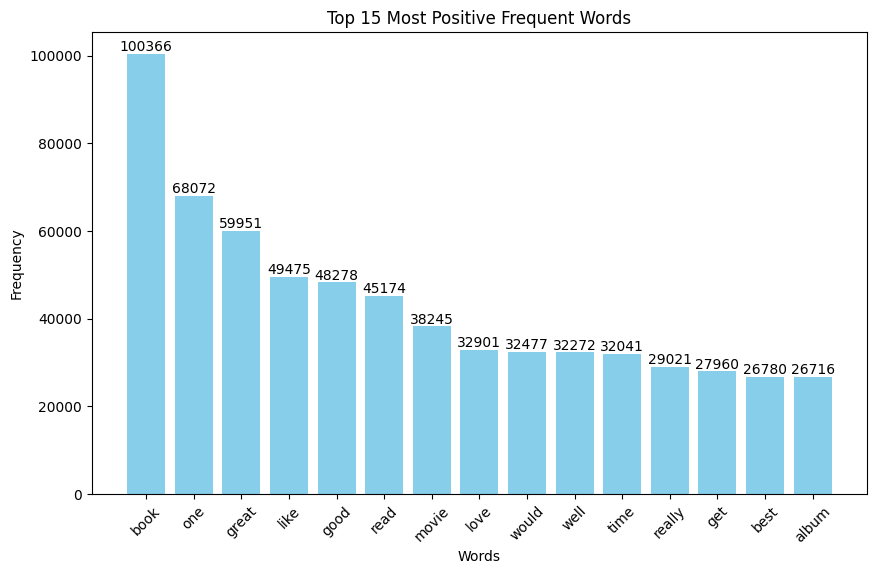

In [ ]:
"""
    Plot top 15 frequently appearing postive words.
"""
words, counts = zip(*top_positive_words)

# Plotting the bar chart
plt.figure(figsize=(10, 6))
plt.bar(words, counts, color='skyblue')

# Adding the numbers on top of the bars
for i, count in enumerate(counts):
    plt.text(i, count + 5, str(count), ha='center', va='bottom')

# Adding labels and title
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title('Top 15 Most Positive Frequent Words')
plt.xticks(rotation=45)  # Rotate x labels for better readability
plt.show()

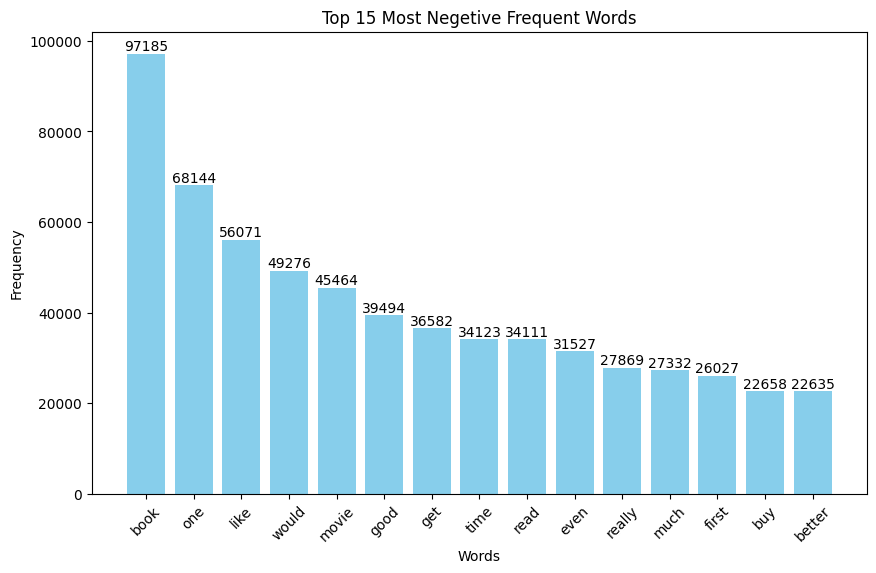

In [ ]:
"""
    Plot top 15 frequently appearing negative words.
"""
words, counts = zip(*top_negetive_words)

# Plotting the bar chart
plt.figure(figsize=(10, 6))
plt.bar(words, counts, color='skyblue')

# Adding the numbers on top of the bars
for i, count in enumerate(counts):
    plt.text(i, count + 5, str(count), ha='center', va='bottom')

# Adding labels and title
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title('Top 15 Most Negetive Frequent Words')
plt.xticks(rotation=45)  # Rotate x labels for better readability
plt.show()

There isn't any clear insight or conclusion by mining frequently occuring words

## Modelling

In [ ]:
# Read pre-processed dataset
x_train = pd.read_pickle('x_train_clean.pkl')
x_test = pd.read_pickle('x_test_clean.pkl')
y_train = pd.read_pickle('y_train_clean.pkl')
y_test = pd.read_pickle('y_test_clean.pkl')

##### What is Tokenization?
##### tokenization is the process of breaking down a text into smaller units called tokens. These tokens could be words, subwords, sentences, or even characters, depending on the specific application and approach.
##### Eg: Word Tokenizer
 #####   Input: "I love programming."
 #####   Output: ["I", "love", "programming", "."]


In [ ]:
"""
    Tokenizer is a utility provided by Keras to convert text into sequences of tokens or numerical representations.
    OOV (Out-Of-Vocabulary) token specifies a placeholder for words not seen during training.
    (<UNK>, <PAD>): Help handle out-of-vocabulary words and sequence padding.
"""
t = Tokenizer(oov_token='<UNK>')
t.fit_on_texts(x_train)
t.word_index['<PAD>'] = 0

In [ ]:
word_counts = t.word_counts

# Sort words by frequency
sorted_words = sorted(word_counts.items(), key=lambda x: x[1], reverse=True)

# Trim vocabulary to top N words (e.g., top 30,000 words)
VOCAB_SIZE = 30000
trimmed_words = sorted_words[:VOCAB_SIZE]

# Create a new tokenizer with the trimmed vocabulary
trimmed_vocab = [word for word, count in trimmed_words]
trimmed_tokenizer = Tokenizer(num_words=VOCAB_SIZE , oov_token='<UNK>')
trimmed_tokenizer.fit_on_texts(trimmed_vocab)

In [159]:
x_train = trimmed_tokenizer.texts_to_sequences(x_train)
x_test = trimmed_tokenizer.texts_to_sequences(x_test)

<Axes: ylabel='Count'>

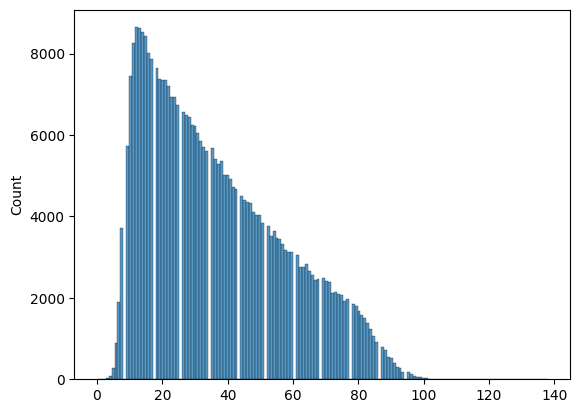

In [ ]:
"""
    Visualise lenght of each token before padding to set maximum sequence lenght for padding.
"""
import seaborn as sns

train_length = [len(s) for s in x_train ]
test_length = [len(s) for s in x_test ]

sns.histplot(train_length)

In [ ]:
# Save x_train
x_train = sequence.pad_sequences(x_train, maxlen=105)
with open('x_train.pkl', 'wb') as f:
    pickle.dump(x_train, f)

# Save x_test
x_test = sequence.pad_sequences(x_test, maxlen=105)
with open('x_test.pkl', 'wb') as f:
    pickle.dump(x_test, f)

### Model Training

In [162]:
import pickle

# Load x_train
with open('x_train.pkl', 'rb') as f:
    x_train = pickle.load(f)

# Load x_test
with open('x_test.pkl', 'rb') as f:
    x_test = pickle.load(f)

In [163]:
EMBEDDING_DIM = 300
MAX_SEQUENCE_LENGTH = 105
VOCAB_SIZE = len(trimmed_tokenizer.word_index) + 1

In [164]:
len(trimmed_tokenizer.word_index)

30001

### CNN

In [165]:
model_cnn = Sequential([
    Embedding(VOCAB_SIZE , EMBEDDING_DIM, input_length=MAX_SEQUENCE_LENGTH),
    Conv1D(32, 3, activation='relu', kernel_regularizer=l2(0.01)),
    BatchNormalization(),
    MaxPooling1D(2),
    Conv1D(64, 3, activation='relu', kernel_regularizer=l2(0.01)),
    BatchNormalization(),
    MaxPooling1D(2),
    Conv1D(128, 3, activation='relu', kernel_regularizer=l2(0.01)),
    BatchNormalization(),
    MaxPooling1D(2),
    Dropout(0.2),
    Flatten(),
    Dense(256, activation='relu', kernel_regularizer=l2(0.01)),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

In [166]:
model_cnn.build(input_shape=(None, MAX_SEQUENCE_LENGTH))

In [167]:
model_cnn.compile(optimizer= 'Adam', loss='binary_crossentropy', metrics=['binary_accuracy'])
model_cnn.summary()

Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_11 (Embedding)        │ (None, 105, 300)       │     9,000,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_22 (Conv1D)              │ (None, 103, 32)        │        28,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_28          │ (None, 103, 32)        │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_22 (MaxPooling1D) │ (None, 51, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_23 (Conv1D)              │ (None, 49, 64)         │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_29          │ (None, 49, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_23 (MaxPooling1D) │ (None, 24, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_24 (Conv1D)              │ (None, 22, 128)        │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_30          │ (None, 22, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_24 (MaxPooling1D) │ (None, 11, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_25 (Dropout)            │ (None, 11, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_8 (Flatten)             │ (None, 1408)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 256)            │       360,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_26 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,422,201 (35.94 MB)

 Trainable params: 9,421,753 (35.94 MB)

 Non-trainable params: 448 (1.75 KB)

In [ ]:
history_cnn = model_cnn.fit(x_train, y_train,validation_data=(x_test,y_test), epochs=5)

Epoch 1/5
11251/11251 ━━━━━━━━━━━━━━━━━━━━ 248s 22ms/step - binary_accuracy: 0.7907 - loss: 1.0528 - val_binary_accuracy: 0.8426 - val_loss: 0.4069
Epoch 2/5
11251/11251 ━━━━━━━━━━━━━━━━━━━━ 239s 21ms/step - binary_accuracy: 0.8576 - loss: 0.3827 - val_binary_accuracy: 0.8419 - val_loss: 0.3982
Epoch 3/5
11251/11251 ━━━━━━━━━━━━━━━━━━━━ 233s 21ms/step - binary_accuracy: 0.8697 - loss: 0.3483 - val_binary_accuracy: 0.8359 - val_loss: 0.4192
Epoch 4/5
11251/11251 ━━━━━━━━━━━━━━━━━━━━ 235s 21ms/step - binary_accuracy: 0.8777 - loss: 0.3319 - val_binary_accuracy: 0.8424 - val_loss: 0.4014
Epoch 5/5
11251/11251 ━━━━━━━━━━━━━━━━━━━━ 233s 21ms/step - binary_accuracy: 0.8864 - loss: 0.3155 - val_binary_accuracy: 0.8536 - val_loss: 0.3814


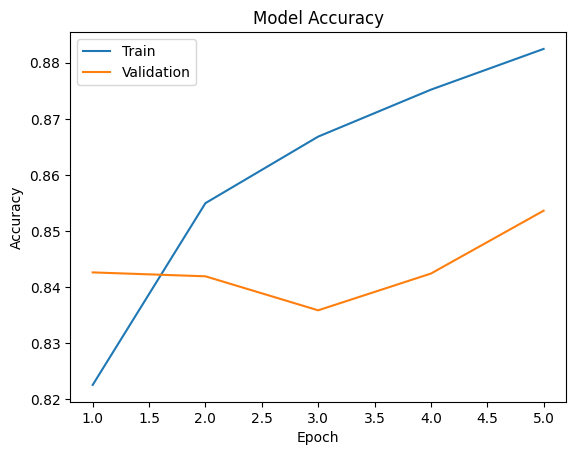

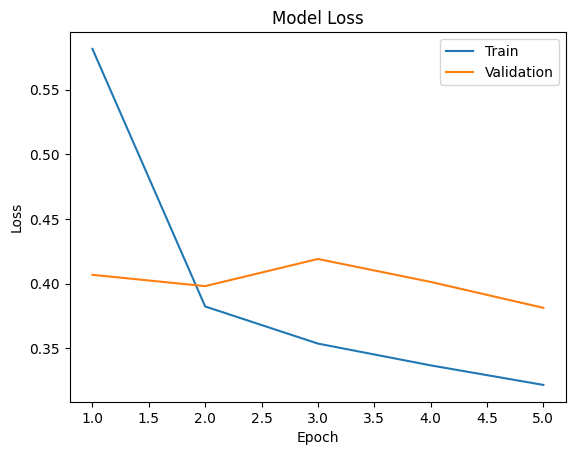

In [173]:
plotLearningCurve(history_cnn,5)

### CNN#2

In [174]:
model_cnn_2 = Sequential([
    Embedding(VOCAB_SIZE, EMBEDDING_DIM, input_length=MAX_SEQUENCE_LENGTH),
    Conv1D(16, 3, activation='relu', kernel_regularizer=l2(0.01)),
    BatchNormalization(),
    MaxPooling1D(2),
    Dropout(0.1),
    Conv1D(32, 3, activation='relu', kernel_regularizer=l2(0.01)),
    BatchNormalization(),
    MaxPooling1D(2),
    Dropout(0.1),
    Conv1D(64, 3, activation='relu', kernel_regularizer=l2(0.01)),
    BatchNormalization(),
    MaxPooling1D(2),
    Dropout(0.2),
    Flatten(),
    Dense(128, activation='relu', kernel_regularizer=l2(0.01)),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

In [175]:
model_cnn_2.build(input_shape=(None, MAX_SEQUENCE_LENGTH))
model_cnn_2.compile(optimizer= 'Adam', loss='binary_crossentropy', metrics=['binary_accuracy'])
model_cnn_2.summary()

Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_12 (Embedding)        │ (None, 105, 300)       │     9,000,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_25 (Conv1D)              │ (None, 103, 16)        │        14,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_31          │ (None, 103, 16)        │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_25 (MaxPooling1D) │ (None, 51, 16)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_27 (Dropout)            │ (None, 51, 16)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_26 (Conv1D)              │ (None, 49, 32)         │         1,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_32          │ (None, 49, 32)         │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_26 (MaxPooling1D) │ (None, 24, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_28 (Dropout)            │ (None, 24, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_27 (Conv1D)              │ (None, 22, 64)         │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_33          │ (None, 22, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_27 (MaxPooling1D) │ (None, 11, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_29 (Dropout)            │ (None, 11, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_9 (Flatten)             │ (None, 704)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 128)            │        90,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_30 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,113,609 (34.77 MB)

 Trainable params: 9,113,385 (34.76 MB)

 Non-trainable params: 224 (896.00 B)

In [176]:
history_cnn2 = model_cnn_2.fit(x_train, y_train,validation_data=(x_test,y_test), epochs=5)

Epoch 1/5
11251/11251 ━━━━━━━━━━━━━━━━━━━━ 205s 18ms/step - binary_accuracy: 0.7809 - loss: 0.8239 - val_binary_accuracy: 0.8461 - val_loss: 0.4045
Epoch 2/5
11251/11251 ━━━━━━━━━━━━━━━━━━━━ 201s 18ms/step - binary_accuracy: 0.8532 - loss: 0.3950 - val_binary_accuracy: 0.8271 - val_loss: 0.4418
Epoch 3/5
11251/11251 ━━━━━━━━━━━━━━━━━━━━ 202s 18ms/step - binary_accuracy: 0.8644 - loss: 0.3684 - val_binary_accuracy: 0.8451 - val_loss: 0.3951
Epoch 4/5
11251/11251 ━━━━━━━━━━━━━━━━━━━━ 202s 18ms/step - binary_accuracy: 0.8714 - loss: 0.3499 - val_binary_accuracy: 0.8481 - val_loss: 0.3969
Epoch 5/5
11251/11251 ━━━━━━━━━━━━━━━━━━━━ 203s 18ms/step - binary_accuracy: 0.8757 - loss: 0.3408 - val_binary_accuracy: 0.8465 - val_loss: 0.3998


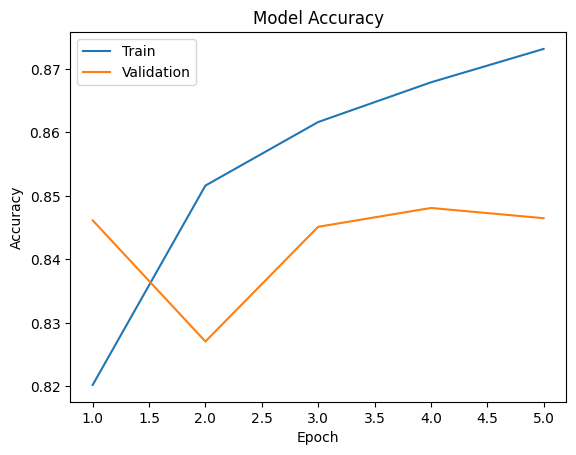

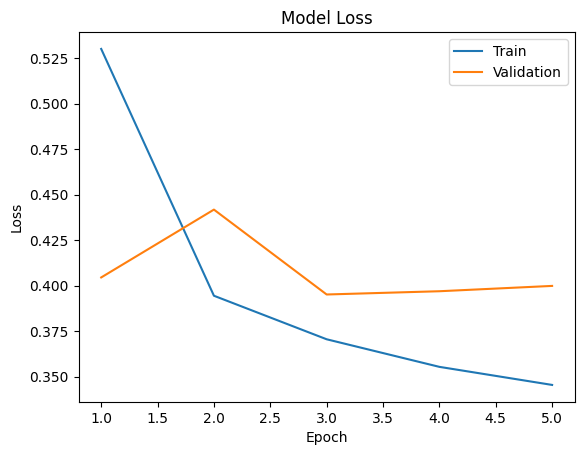

In [180]:
plotLearningCurve(history_cnn2,5)

### RNN#1

In [202]:
model_rnn_1 = Sequential([
    Embedding(VOCAB_SIZE, EMBEDDING_DIM, input_length=MAX_SEQUENCE_LENGTH),
    SimpleRNN(50 , activation= 'relu' , kernel_regularizer= l2(0.01) , return_sequences= True),
    BatchNormalization(),
    Dropout(0.1),
    SimpleRNN(100 , activation= 'relu' , kernel_regularizer= l2(0.01)),
    Dropout(0.1),
    Dense(250 , activation= 'relu' , kernel_regularizer= l2(0.01)),
    Dropout(0.2),
    Dense(1 , activation= 'sigmoid' )])

In [203]:
model_rnn_1.build(input_shape=(None, MAX_SEQUENCE_LENGTH))
model_rnn_1.compile(optimizer= 'Adam', loss='binary_crossentropy', metrics=['binary_accuracy'])
model_rnn_1.summary()

Model: "sequential_19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_19 (Embedding)        │ (None, 105, 300)       │     9,000,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_7 (SimpleRNN)        │ (None, 105, 50)        │        17,550 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_44          │ (None, 105, 50)        │           200 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_50 (Dropout)            │ (None, 105, 50)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_8 (SimpleRNN)        │ (None, 100)            │        15,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_51 (Dropout)            │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_36 (Dense)                │ (None, 250)            │        25,250 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_52 (Dropout)            │ (None, 250)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_37 (Dense)                │ (None, 1)              │           251 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,058,951 (34.56 MB)

 Trainable params: 9,058,851 (34.56 MB)

 Non-trainable params: 100 (400.00 B)

In [204]:
history_rnn1 = model_rnn_1.fit(x_train, y_train,validation_data=(x_test,y_test), epochs=5)

Epoch 1/5
11251/11251 ━━━━━━━━━━━━━━━━━━━━ 448s 40ms/step - binary_accuracy: 0.8176 - loss: 0.5592 - val_binary_accuracy: 0.8479 - val_loss: 0.3943
Epoch 2/5
11251/11251 ━━━━━━━━━━━━━━━━━━━━ 454s 40ms/step - binary_accuracy: 0.8744 - loss: 0.3298 - val_binary_accuracy: 0.8607 - val_loss: 0.3964
Epoch 3/5
11251/11251 ━━━━━━━━━━━━━━━━━━━━ 453s 40ms/step - binary_accuracy: 0.8862 - loss: 0.3203 - val_binary_accuracy: 0.8684 - val_loss: 0.3281
Epoch 4/5
11251/11251 ━━━━━━━━━━━━━━━━━━━━ 459s 41ms/step - binary_accuracy: 0.8922 - loss: 0.2886 - val_binary_accuracy: 0.8598 - val_loss: 0.3941
Epoch 5/5
11251/11251 ━━━━━━━━━━━━━━━━━━━━ 457s 41ms/step - binary_accuracy: 0.8974 - loss: 0.2774 - val_binary_accuracy: 0.8679 - val_loss: 0.3290


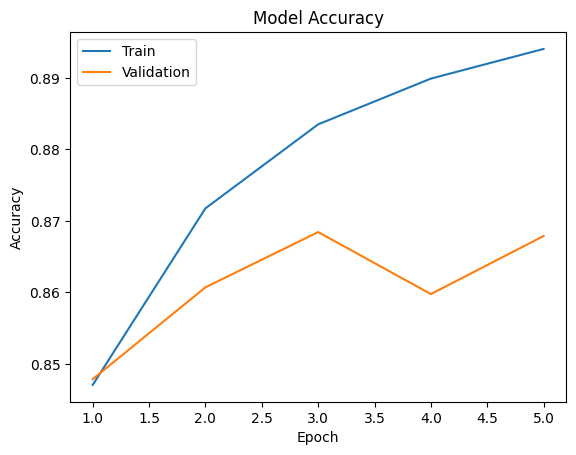

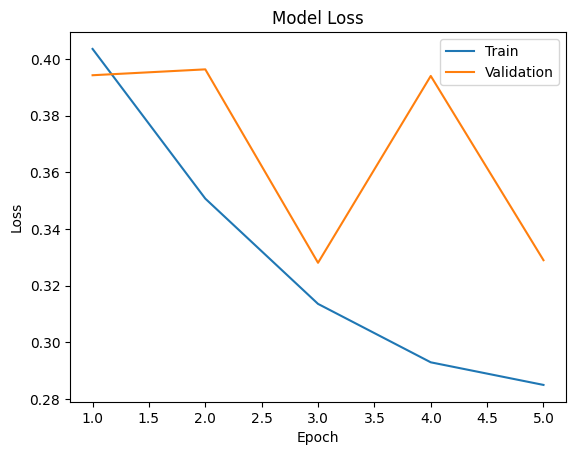

In [205]:
plotLearningCurve(history_rnn1,5)

### LSTM#1

In [184]:
model_lstm_1 = Sequential([
    Embedding(VOCAB_SIZE, EMBEDDING_DIM, input_length=MAX_SEQUENCE_LENGTH),
    LSTM(50 , activation= 'relu' , kernel_regularizer= l2(0.01) , return_sequences= True),
    BatchNormalization(),
    Dropout(0.1),
    LSTM(100 , activation= 'relu' , kernel_regularizer= l2(0.01)),
    BatchNormalization(),
    Dropout(0.1),
    LSTM(150 , activation= 'relu' , kernel_regularizer= l2(0.01)),
    BatchNormalization(),
    Dropout(0.2),
    Dense(1 , activation= 'sigmoid' )])

In [185]:
model_lstm_1.build(input_shape=(None, MAX_SEQUENCE_LENGTH))
model_lstm_1.compile(optimizer= 'Adam', loss='binary_crossentropy', metrics=['binary_accuracy'])
model_lstm_1.summary()

ValueError: Input 0 of layer "lstm_8" is incompatible with the layer: expected ndim=3, found ndim=2. Full shape received: (None, 100)

In [ ]:
history_lstm1 = model_lstm_1.fit(x_train, y_train,validation_data=(x_test,y_test), epochs=5)

Epoch 1/5
11251/11251 ━━━━━━━━━━━━━━━━━━━━ 1027s 91ms/step - binary_accuracy: 0.5111 - loss: 311567712.0000 - val_binary_accuracy: 0.4998 - val_loss: 1.6753
Epoch 2/5
11251/11251 ━━━━━━━━━━━━━━━━━━━━ 969s 86ms/step - binary_accuracy: 0.5058 - loss: 45055307776.0000 - val_binary_accuracy: 0.5000 - val_loss: 134.3586
Epoch 3/5
11251/11251 ━━━━━━━━━━━━━━━━━━━━ 978s 87ms/step - binary_accuracy: 0.5073 - loss: 1567.9200 - val_binary_accuracy: 0.5000 - val_loss: 1.7252
Epoch 4/5
11251/11251 ━━━━━━━━━━━━━━━━━━━━ 1024s 91ms/step - binary_accuracy: 0.5066 - loss: 210.9787 - val_binary_accuracy: 0.5000 - val_loss: 1.6951
Epoch 5/5
11251/11251 ━━━━━━━━━━━━━━━━━━━━ 1022s 91ms/step - binary_accuracy: 0.5067 - loss: 4.1792 - val_binary_accuracy: 0.5000 - val_loss: 2.2198


In [ ]:
plotLearningCurve(history_lstm1,5)

### Bi-LSTM#1

In [206]:
model_bilstm_1 = Sequential([
    Embedding(VOCAB_SIZE, EMBEDDING_DIM, input_length=MAX_SEQUENCE_LENGTH),
    Bidirectional(LSTM(50 , activation= 'relu' , kernel_regularizer= l2(0.01) , return_sequences= True)),
    BatchNormalization(),
    Dropout(0.1),
    Flatten(),
    Dense(128 , activation= 'relu' , kernel_regularizer= l2(0.01)),
    Dropout(0.2),
    Dense(1 , activation= 'sigmoid' )])

In [207]:
model_bilstm_1.build(input_shape=(None, MAX_SEQUENCE_LENGTH))
model_bilstm_1.compile(optimizer= 'Adam', loss='binary_crossentropy', metrics=['binary_accuracy'])
model_bilstm_1.summary()

Model: "sequential_20"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_20 (Embedding)        │ (None, 105, 300)       │     9,000,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_4 (Bidirectional) │ (None, 105, 100)       │       140,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_45          │ (None, 105, 100)       │           400 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_53 (Dropout)            │ (None, 105, 100)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_11 (Flatten)            │ (None, 10500)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_38 (Dense)                │ (None, 128)            │     1,344,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_54 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_39 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,485,657 (40.00 MB)

 Trainable params: 10,485,457 (40.00 MB)

 Non-trainable params: 200 (800.00 B)

In [208]:
history_bilstm1 = model_bilstm_1.fit(x_train, y_train,validation_data=(x_test,y_test), epochs=5)

Epoch 1/5
11251/11251 ━━━━━━━━━━━━━━━━━━━━ 1116s 99ms/step - binary_accuracy: 0.8292 - loss: 0.5692 - val_binary_accuracy: 0.8657 - val_loss: 0.3594
Epoch 2/5
11251/11251 ━━━━━━━━━━━━━━━━━━━━ 1122s 100ms/step - binary_accuracy: 0.8753 - loss: 0.3333 - val_binary_accuracy: 0.8698 - val_loss: 0.3400
Epoch 3/5
11251/11251 ━━━━━━━━━━━━━━━━━━━━ 1129s 100ms/step - binary_accuracy: 0.8854 - loss: 0.3127 - val_binary_accuracy: 0.8588 - val_loss: 0.3806
Epoch 4/5
11251/11251 ━━━━━━━━━━━━━━━━━━━━ 1137s 101ms/step - binary_accuracy: 0.8936 - loss: 0.2930 - val_binary_accuracy: 0.8651 - val_loss: 0.3985
Epoch 5/5
11251/11251 ━━━━━━━━━━━━━━━━━━━━ 1147s 102ms/step - binary_accuracy: 0.8955 - loss: 0.3138 - val_binary_accuracy: 0.8589 - val_loss: 0.4546


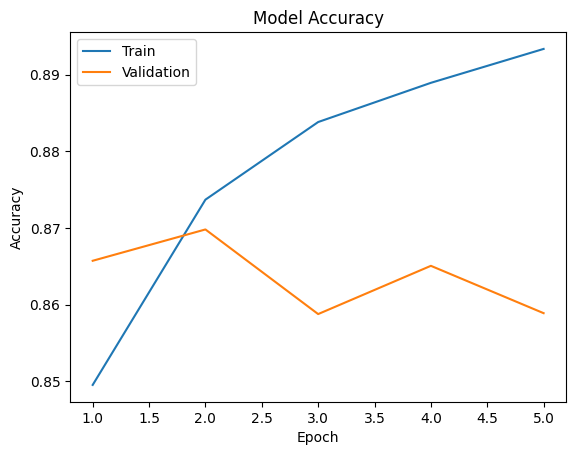

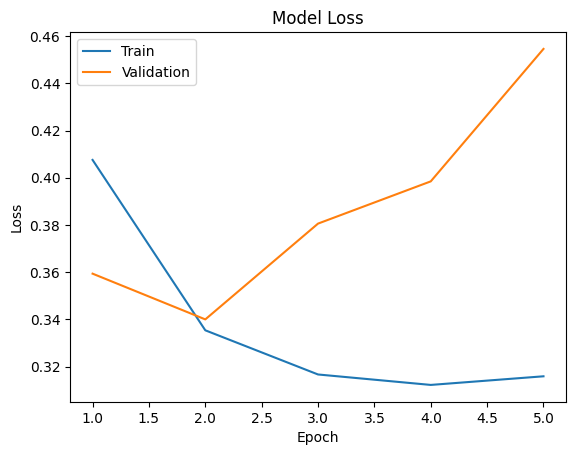

In [209]:
plotLearningCurve(history_bilstm1,5)

### RNN + CNN #1

In [189]:
model_rnn_cnn_1 = Sequential([
    Embedding(VOCAB_SIZE, EMBEDDING_DIM, input_length=MAX_SEQUENCE_LENGTH),
    Conv1D(64, 3, activation='relu', kernel_regularizer=l2(0.01)),
    BatchNormalization(),
    MaxPooling1D(2),
    Dropout(0.1),
    # Flatten(),
    SimpleRNN(100 , activation= 'relu' , kernel_regularizer= l2(0.01)),
    Dropout(0.1),
    Dense(128 , activation= 'relu' , kernel_regularizer= l2(0.01)),
    Dropout(0.2),
    Dense(1 , activation= 'sigmoid' )
])


In [190]:
model_rnn_cnn_1.build(input_shape=(None, MAX_SEQUENCE_LENGTH))
model_rnn_cnn_1.compile(optimizer= 'Adam', loss='binary_crossentropy', metrics=['binary_accuracy'])
model_rnn_cnn_1.summary()

Model: "sequential_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_16 (Embedding)        │ (None, 105, 300)       │     9,000,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_28 (Conv1D)              │ (None, 103, 64)        │        57,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_40          │ (None, 103, 64)        │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_28 (MaxPooling1D) │ (None, 51, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_39 (Dropout)            │ (None, 51, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_3 (SimpleRNN)        │ (None, 100)            │        16,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_40 (Dropout)            │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_30 (Dense)                │ (None, 128)            │        12,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_41 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_31 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,088,077 (34.67 MB)

 Trainable params: 9,087,949 (34.67 MB)

 Non-trainable params: 128 (512.00 B)

In [191]:
history_rnn_cnn1 = model_rnn_cnn_1.fit(x_train, y_train,validation_data=(x_test,y_test), epochs=5)

Epoch 1/5
11251/11251 ━━━━━━━━━━━━━━━━━━━━ 270s 24ms/step - binary_accuracy: 0.8099 - loss: 0.6092 - val_binary_accuracy: 0.8495 - val_loss: 0.3857
Epoch 2/5
11251/11251 ━━━━━━━━━━━━━━━━━━━━ 264s 23ms/step - binary_accuracy: 0.8711 - loss: 0.3344 - val_binary_accuracy: 0.8583 - val_loss: 0.3663
Epoch 3/5
11251/11251 ━━━━━━━━━━━━━━━━━━━━ 265s 24ms/step - binary_accuracy: 0.8812 - loss: 0.3158 - val_binary_accuracy: 0.8403 - val_loss: 0.4186
Epoch 4/5
11251/11251 ━━━━━━━━━━━━━━━━━━━━ 266s 24ms/step - binary_accuracy: 0.8863 - loss: 0.3086 - val_binary_accuracy: 0.8582 - val_loss: 0.3588
Epoch 5/5
11251/11251 ━━━━━━━━━━━━━━━━━━━━ 266s 24ms/step - binary_accuracy: 0.8930 - loss: 0.2939 - val_binary_accuracy: 0.8544 - val_loss: 0.3828


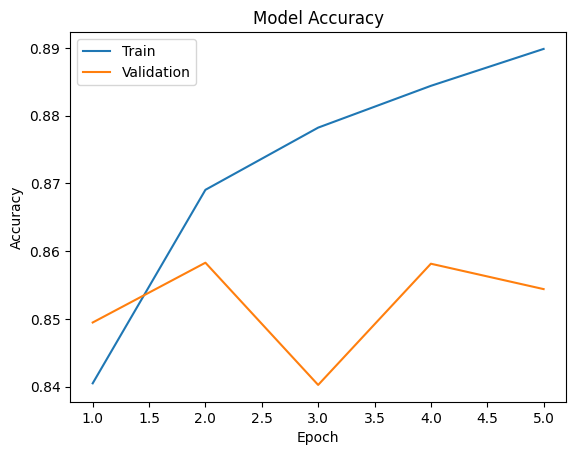

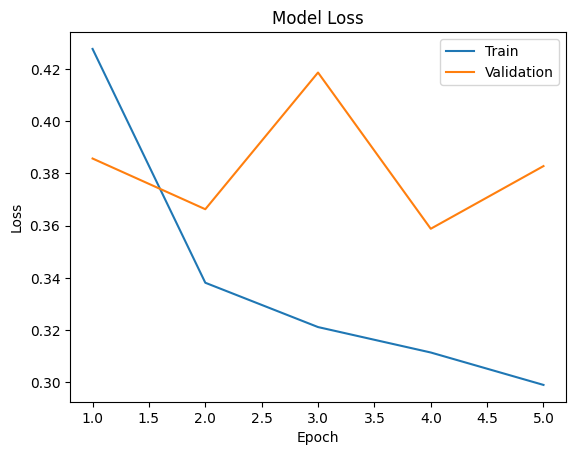

In [193]:
plotLearningCurve(history_rnn_cnn1,5)

### RNN + CNN#2

In [194]:
model_rnn_cnn_2 = Sequential([
    Embedding(VOCAB_SIZE, EMBEDDING_DIM, input_length=MAX_SEQUENCE_LENGTH),
    Conv1D(32, 3, activation='relu', kernel_regularizer=l2(0.01)),
    BatchNormalization(),
    MaxPooling1D(2),
    Dropout(0.1),
    # Flatten(),
    Bidirectional(SimpleRNN(50 , activation= 'relu' , kernel_regularizer= l2(0.01), return_sequences= True)),
    Dropout(0.1),
    Bidirectional(SimpleRNN(100 , activation= 'relu' , kernel_regularizer= l2(0.01))),
    Dropout(0.1),
    Dense(128 , activation= 'relu' , kernel_regularizer= l2(0.01)),
    Dropout(0.2),
    Dense(1 , activation= 'sigmoid' )
])

In [195]:
model_rnn_cnn_2.build(input_shape=(None, MAX_SEQUENCE_LENGTH))
model_rnn_cnn_2.compile(optimizer= 'Adam', loss='binary_crossentropy', metrics=['binary_accuracy'])
model_rnn_cnn_2.summary()

Model: "sequential_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_17 (Embedding)        │ (None, 105, 300)       │     9,000,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_29 (Conv1D)              │ (None, 103, 32)        │        28,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_41          │ (None, 103, 32)        │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_29 (MaxPooling1D) │ (None, 51, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_42 (Dropout)            │ (None, 51, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ (None, 51, 100)        │         8,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_43 (Dropout)            │ (None, 51, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_3 (Bidirectional) │ (None, 200)            │        40,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_44 (Dropout)            │ (None, 200)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_32 (Dense)                │ (None, 128)            │        25,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_45 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_33 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,103,917 (34.73 MB)

 Trainable params: 9,103,853 (34.73 MB)

 Non-trainable params: 64 (256.00 B)

In [196]:
history_rnn_cnn2 = model_rnn_cnn_2.fit(x_train, y_train,validation_data=(x_test,y_test), epochs=5)

Epoch 1/5
11251/11251 ━━━━━━━━━━━━━━━━━━━━ 421s 37ms/step - binary_accuracy: 0.8103 - loss: 0.6620 - val_binary_accuracy: 0.8616 - val_loss: 0.3518
Epoch 2/5
11251/11251 ━━━━━━━━━━━━━━━━━━━━ 420s 37ms/step - binary_accuracy: 0.8704 - loss: 0.3481 - val_binary_accuracy: 0.8641 - val_loss: 0.3507
Epoch 3/5
11251/11251 ━━━━━━━━━━━━━━━━━━━━ 429s 38ms/step - binary_accuracy: 0.8808 - loss: 0.3193 - val_binary_accuracy: 0.8592 - val_loss: 0.3510
Epoch 4/5
11251/11251 ━━━━━━━━━━━━━━━━━━━━ 420s 37ms/step - binary_accuracy: 0.8879 - loss: 0.3055 - val_binary_accuracy: 0.8638 - val_loss: 0.3579
Epoch 5/5
11251/11251 ━━━━━━━━━━━━━━━━━━━━ 425s 38ms/step - binary_accuracy: 0.8946 - loss: 0.2925 - val_binary_accuracy: 0.8633 - val_loss: 0.3486


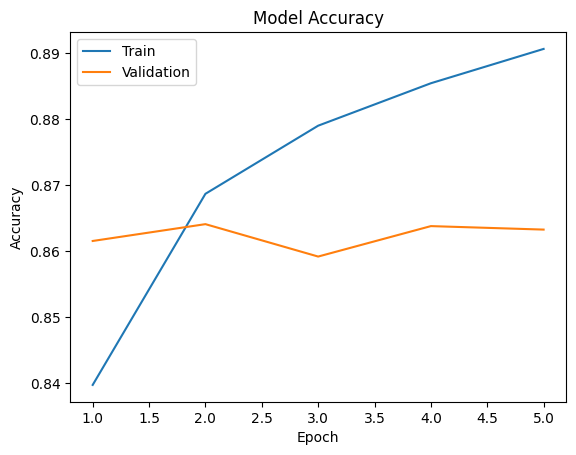

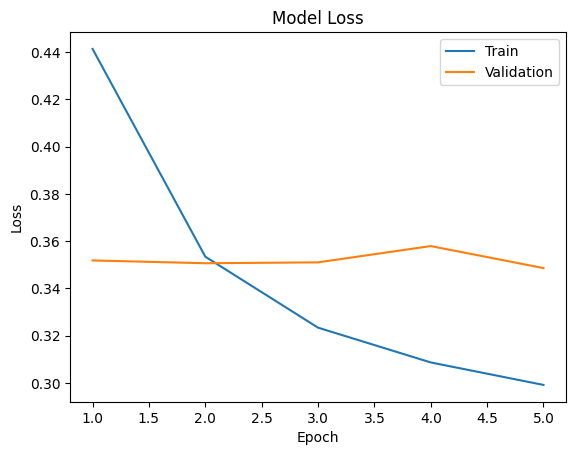

In [197]:
plotLearningCurve(history_rnn_cnn2,5)

### RNN + CNN#3

In [198]:
model_rnn_cnn_3 = Sequential([
    Embedding(VOCAB_SIZE, EMBEDDING_DIM, input_length=MAX_SEQUENCE_LENGTH),
    Conv1D(8, 3, activation='relu', kernel_regularizer=l2(0.01)),
    BatchNormalization(),
    MaxPooling1D(2),
    Conv1D(32, 3, activation='relu', kernel_regularizer=l2(0.01)),
    BatchNormalization(),
    MaxPooling1D(2),
    Dropout(0.1),
    # Flatten(),
    SimpleRNN(16 , activation= 'relu' , kernel_regularizer= l2(0.01), return_sequences= True),
    Dropout(0.1),
    LSTM(64 , activation= 'relu' , kernel_regularizer= l2(0.01)),
    Dropout(0.1),
    Dense(128 , activation= 'relu' , kernel_regularizer= l2(0.01)),
    Dropout(0.2),
    Dense(1 , activation= 'sigmoid' )
])

In [199]:
model_rnn_cnn_3.build(input_shape=(None, MAX_SEQUENCE_LENGTH))
model_rnn_cnn_3.compile(optimizer= 'Adam', loss='binary_crossentropy', metrics=['binary_accuracy'])
model_rnn_cnn_3.summary()

Model: "sequential_18"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_18 (Embedding)        │ (None, 105, 300)       │     9,000,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_30 (Conv1D)              │ (None, 103, 8)         │         7,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_42          │ (None, 103, 8)         │            32 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_30 (MaxPooling1D) │ (None, 51, 8)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_31 (Conv1D)              │ (None, 49, 32)         │           800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_43          │ (None, 49, 32)         │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_31 (MaxPooling1D) │ (None, 24, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_46 (Dropout)            │ (None, 24, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_6 (SimpleRNN)        │ (None, 24, 16)         │           784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_47 (Dropout)            │ (None, 24, 16)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_10 (LSTM)                  │ (None, 64)             │        20,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_48 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_34 (Dense)                │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_49 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_35 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,038,737 (34.48 MB)

 Trainable params: 9,038,657 (34.48 MB)

 Non-trainable params: 80 (320.00 B)

In [200]:
history_rnn_cnn3 = model_rnn_cnn_3.fit(x_train, y_train,validation_data=(x_test,y_test), epochs=5)

Epoch 1/5
11251/11251 ━━━━━━━━━━━━━━━━━━━━ 237s 21ms/step - binary_accuracy: 0.8092 - loss: 0.5405 - val_binary_accuracy: 0.8477 - val_loss: 0.3716
Epoch 2/5
11251/11251 ━━━━━━━━━━━━━━━━━━━━ 232s 21ms/step - binary_accuracy: 0.8599 - loss: 0.3567 - val_binary_accuracy: 0.8521 - val_loss: 0.3653
Epoch 3/5
11251/11251 ━━━━━━━━━━━━━━━━━━━━ 226s 20ms/step - binary_accuracy: 0.8734 - loss: 0.3294 - val_binary_accuracy: 0.8549 - val_loss: 0.3605
Epoch 4/5
11251/11251 ━━━━━━━━━━━━━━━━━━━━ 231s 21ms/step - binary_accuracy: 0.8825 - loss: 0.3128 - val_binary_accuracy: 0.8487 - val_loss: 0.3702
Epoch 5/5
11251/11251 ━━━━━━━━━━━━━━━━━━━━ 233s 21ms/step - binary_accuracy: 0.8904 - loss: 0.2969 - val_binary_accuracy: 0.8453 - val_loss: 0.3819


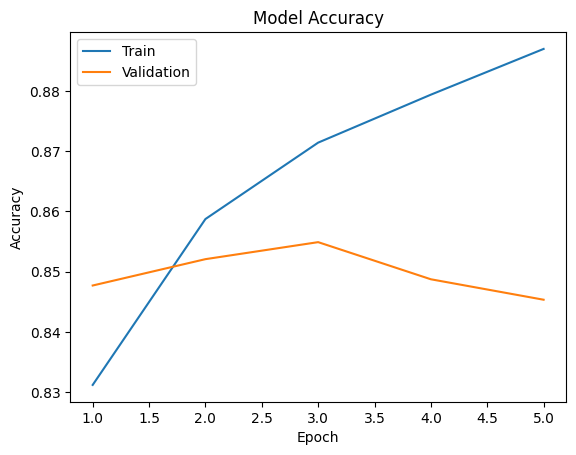

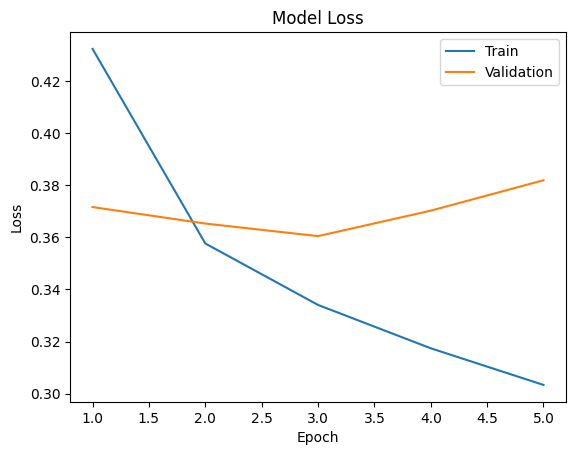

In [201]:
plotLearningCurve(history_rnn_cnn3,5)

### ANN#1

In [210]:
model_ann_1 = Sequential([
    Dense(32, activation='relu',input_dim = 105 ,kernel_regularizer=l2(0.01)),
    BatchNormalization(),
    Dropout(0.1),
    Dense(64, activation='relu',input_dim = 105 ,kernel_regularizer=l2(0.01)),
    BatchNormalization(),
    Dropout(0.1),
    Dense(128 , activation= 'relu' , kernel_regularizer= l2(0.01)),
    Dropout(0.1),
    Dense(256 , activation= 'relu' , kernel_regularizer= l2(0.01)),
    Dropout(0.2),
    Dense(1 , activation= 'sigmoid' )
])

In [211]:
model_ann_1.build(input_shape=(None, MAX_SEQUENCE_LENGTH))
model_ann_1.compile(optimizer= 'Adam', loss='binary_crossentropy', metrics=['binary_accuracy'])
model_ann_1.summary()

Model: "sequential_21"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_40 (Dense)                │ (None, 32)             │         3,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_46          │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_55 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_41 (Dense)                │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_47          │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_56 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_42 (Dense)                │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_57 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_43 (Dense)                │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_58 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_44 (Dense)                │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 47,489 (185.50 KB)

 Trainable params: 47,297 (184.75 KB)

 Non-trainable params: 192 (768.00 B)

In [212]:
history_ann1 = model_ann_1.fit(x_train, y_train,validation_data=(x_test,y_test), epochs=5)

Epoch 1/5
11251/11251 ━━━━━━━━━━━━━━━━━━━━ 11s 897us/step - binary_accuracy: 0.5048 - loss: 0.8803 - val_binary_accuracy: 0.5000 - val_loss: 0.6932
Epoch 2/5
11251/11251 ━━━━━━━━━━━━━━━━━━━━ 10s 899us/step - binary_accuracy: 0.5058 - loss: 0.6931 - val_binary_accuracy: 0.5000 - val_loss: 0.6935
Epoch 3/5
11251/11251 ━━━━━━━━━━━━━━━━━━━━ 10s 901us/step - binary_accuracy: 0.5063 - loss: 0.6931 - val_binary_accuracy: 0.5000 - val_loss: 0.6932
Epoch 4/5
11251/11251 ━━━━━━━━━━━━━━━━━━━━ 10s 880us/step - binary_accuracy: 0.5077 - loss: 0.6931 - val_binary_accuracy: 0.5000 - val_loss: 0.6932
Epoch 5/5
11251/11251 ━━━━━━━━━━━━━━━━━━━━ 10s 890us/step - binary_accuracy: 0.5081 - loss: 0.6930 - val_binary_accuracy: 0.5000 - val_loss: 0.6934


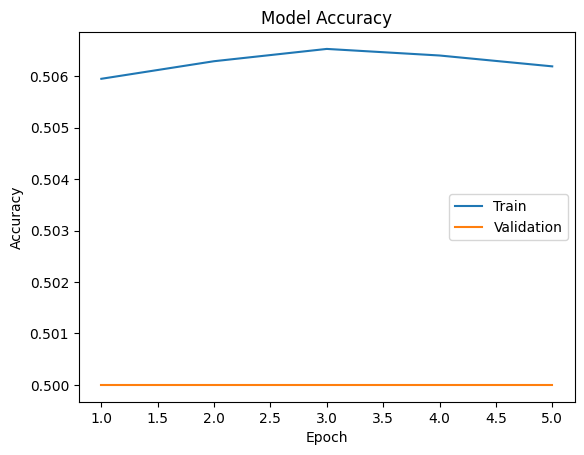

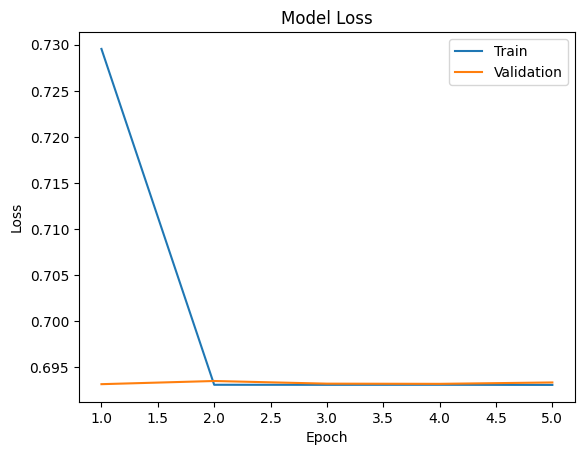

In [213]:
plotLearningCurve(history_ann1,5)

We will pick between #1 RNN model and #2 RNN + CNN model because it has better cross val accuracy and training accuracy

Train RNN+CNN #1 model with full dataset and save the best performing model in pickle file for reuse

## Final Model Pick

In [44]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

In [45]:
column_names = ['flag', 'review_header', 'review']
train_df.columns = column_names
test_df.columns = column_names

In [46]:
x_train = train_df['review'].str.lower().replace('[^\w\s]', ' ').replace('\d', ' ')
y_train = train_df['flag'].astype(int) - 1
x_test = test_df['review'].str.lower().replace('[^\w\s]', ' ').replace('\d', ' ')
y_test = test_df['flag'].astype(int) - 1

In [47]:
def clean_text(text):
    if isinstance(text, str):
        # Remove all characters except a-z, A-Z, and spaces
        text = re.sub(r'[^a-zA-Z\s]', ' ', text)
        return text
    return text

In [48]:
x_train = x_train.apply(clean_text)
x_test = x_test.apply(clean_text)

In [8]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/pranitdas/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [9]:
sw = stopwords.words('english')

In [10]:
x_train = x_train.apply(lambda x: " ".join(x for x in str(x).split() if x not in sw))
x_test = x_test.apply(lambda x: " ".join(x for x in str(x).split() if x not in sw))

In [11]:
word_count = pd.Series(' '.join(x_train).split()).value_counts()
filter_word = word_count[word_count < 10]

In [12]:
x_train = x_train.apply(lambda x: " ".join(x for x in x.split() if x not in filter_word))

In [ ]:
x_train.to_pickle('x_train_final_clean.pkl')
x_test.to_pickle('x_test_final_clean.pkl')
y_train.to_pickle('y_train_final_clean.pkl')
y_test.to_pickle('y_test_final_clean.pkl')

### 30000 Vocal size

In [58]:
x_train = pd.read_pickle('x_train_final_clean.pkl')
x_test = pd.read_pickle('x_test_final_clean.pkl')

In [14]:
t = Tokenizer(oov_token='<UNK>')
t.fit_on_texts(x_train)
t.word_index['<PAD>'] = 0

In [15]:
word_counts = t.word_counts

# Sort words by frequency
sorted_words = sorted(word_counts.items(), key=lambda x: x[1], reverse=True)

# Trim vocabulary to top N words (e.g., top 50,000 words)
VOCAB_SIZE = 30000
trimmed_words = sorted_words[:VOCAB_SIZE]

# Create a new tokenizer with the trimmed vocabulary
trimmed_vocab = [word for word, count in trimmed_words]
trimmed_tokenizer = Tokenizer(num_words=VOCAB_SIZE , oov_token='<UNK>')
trimmed_tokenizer.fit_on_texts(trimmed_vocab)

In [16]:
train_sequences = trimmed_tokenizer.texts_to_sequences(x_train)
test_sequences = trimmed_tokenizer.texts_to_sequences(x_test)

<Axes: ylabel='Count'>

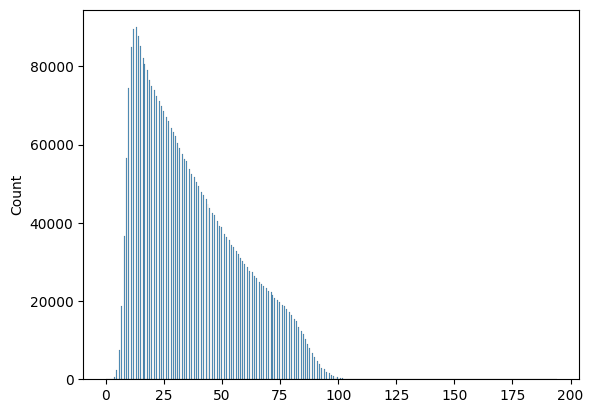

In [17]:
import seaborn as sns

train_length = [len(s) for s in train_sequences]
test_length = [len(s) for s in test_sequences]

sns.histplot(train_length)

In [18]:
x_train = sequence.pad_sequences(train_sequences, maxlen=105)
x_test = sequence.pad_sequences(test_sequences, maxlen=105)

In [19]:
EMBEDDING_DIM = 300
MAX_SEQUENCE_LENGTH = 105
VOCAB_SIZE = len(trimmed_tokenizer.word_index) 
print(len(trimmed_tokenizer.word_index)) 

30001


### RNN

In [20]:
model_rnn = Sequential([
    Embedding(VOCAB_SIZE, EMBEDDING_DIM, input_length=MAX_SEQUENCE_LENGTH),
    SimpleRNN(50 , activation= 'relu' , kernel_regularizer= l2(0.01) , return_sequences= True),
    BatchNormalization(),
    Dropout(0.1),
    SimpleRNN(100 , activation= 'relu' , kernel_regularizer= l2(0.01)),
    Dropout(0.1),
    Dense(250 , activation= 'relu' , kernel_regularizer= l2(0.01)),
    Dropout(0.2),
    Dense(1 , activation= 'sigmoid' )])

In [21]:
model_rnn.build(input_shape=(None, MAX_SEQUENCE_LENGTH))
model_rnn.compile(optimizer= 'Adam', loss='binary_crossentropy', metrics=['binary_accuracy'])
model_rnn.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 105, 300)       │     9,000,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn (SimpleRNN)          │ (None, 105, 50)        │        17,550 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 105, 50)        │           200 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 105, 50)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_1 (SimpleRNN)        │ (None, 100)            │        15,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 250)            │        25,250 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 250)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           251 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,058,651 (34.56 MB)

 Trainable params: 9,058,551 (34.56 MB)

 Non-trainable params: 100 (400.00 B)

In [22]:
history_rnn = model_rnn.fit(x_train, y_train,validation_data=(x_test,y_test), epochs=5)

Epoch 1/5
112500/112500 ━━━━━━━━━━━━━━━━━━━━ 4013s 36ms/step - binary_accuracy: 0.8578 - loss: 0.3826 - val_binary_accuracy: 0.8836 - val_loss: 0.3013
Epoch 2/5
112500/112500 ━━━━━━━━━━━━━━━━━━━━ 3951s 35ms/step - binary_accuracy: 0.7522 - loss: 0.4543 - val_binary_accuracy: 0.8775 - val_loss: 0.3274
Epoch 3/5
112500/112500 ━━━━━━━━━━━━━━━━━━━━ 3953s 35ms/step - binary_accuracy: 0.8787 - loss: 0.3182 - val_binary_accuracy: 0.8480 - val_loss: 0.3844
Epoch 4/5
112500/112500 ━━━━━━━━━━━━━━━━━━━━ 4087s 36ms/step - binary_accuracy: 0.8808 - loss: 0.3326 - val_binary_accuracy: 0.8829 - val_loss: 0.3310
Epoch 5/5
112500/112500 ━━━━━━━━━━━━━━━━━━━━ 3937s 35ms/step - binary_accuracy: 0.8565 - loss: 0.3658 - val_binary_accuracy: 0.5000 - val_loss: 0.6951


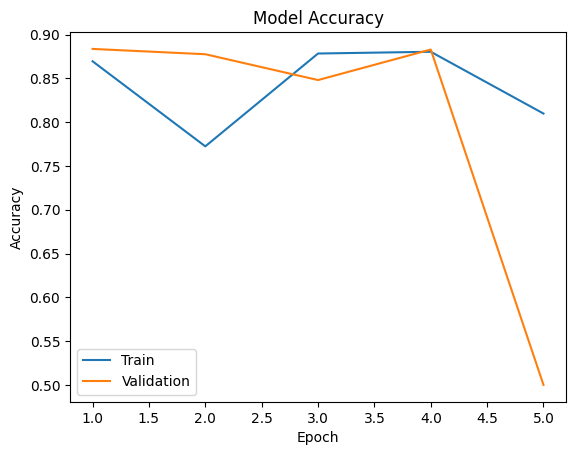

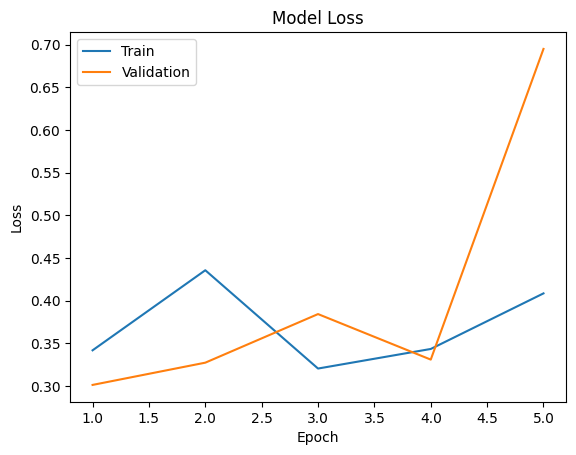

In [39]:
plotLearningCurve(history_rnn,5)

In [25]:
model_rnn.save('Review_score_model_rnn.h5')

In [26]:
model_rnn.save('review_score_model_rnn.keras')

### CNN + RNN

In [27]:
model_cnn_rnn = Sequential([
    Embedding(VOCAB_SIZE, EMBEDDING_DIM, input_length=MAX_SEQUENCE_LENGTH),
    Conv1D(32, 3, activation='relu', kernel_regularizer=l2(0.01)),
    BatchNormalization(),
    MaxPooling1D(2),
    Dropout(0.1),
    # Flatten(),
    Bidirectional(SimpleRNN(50 , activation= 'relu' , kernel_regularizer= l2(0.01), return_sequences= True)),
    Dropout(0.1),
    Bidirectional(SimpleRNN(100 , activation= 'relu' , kernel_regularizer= l2(0.01))),
    Dropout(0.1),
    Dense(128 , activation= 'relu' , kernel_regularizer= l2(0.01)),
    Dropout(0.2),
    Dense(1 , activation= 'sigmoid' )
])

In [28]:
model_cnn_rnn.build(input_shape=(None, MAX_SEQUENCE_LENGTH))
model_cnn_rnn.compile(optimizer= 'Adam', loss='binary_crossentropy', metrics=['binary_accuracy'])
model_cnn_rnn.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ (None, 105, 300)       │     9,000,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 103, 32)        │        28,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 103, 32)        │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 51, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 51, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 51, 100)        │         8,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 51, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 200)            │        40,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 200)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        25,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,103,617 (34.73 MB)

 Trainable params: 9,103,553 (34.73 MB)

 Non-trainable params: 64 (256.00 B)

In [29]:
history_cnn_rnn = model_cnn_rnn.fit(x_train, y_train,validation_data=(x_test,y_test), epochs=5)

Epoch 1/5
112500/112500 ━━━━━━━━━━━━━━━━━━━━ 3667s 33ms/step - binary_accuracy: 0.8496 - loss: 0.4069 - val_binary_accuracy: 0.8673 - val_loss: 0.3338
Epoch 2/5
112500/112500 ━━━━━━━━━━━━━━━━━━━━ 3733s 33ms/step - binary_accuracy: 0.8648 - loss: 0.3505 - val_binary_accuracy: 0.8612 - val_loss: 0.3865
Epoch 3/5
112500/112500 ━━━━━━━━━━━━━━━━━━━━ 3707s 33ms/step - binary_accuracy: 0.8546 - loss: 0.3919 - val_binary_accuracy: 0.8706 - val_loss: 0.3270
Epoch 4/5
112500/112500 ━━━━━━━━━━━━━━━━━━━━ 3710s 33ms/step - binary_accuracy: 0.7776 - loss: 0.6609 - val_binary_accuracy: 0.5000 - val_loss: 1.2516
Epoch 5/5
112500/112500 ━━━━━━━━━━━━━━━━━━━━ 3712s 33ms/step - binary_accuracy: 0.6110 - loss: 0.9622 - val_binary_accuracy: 0.5000 - val_loss: 0.9535


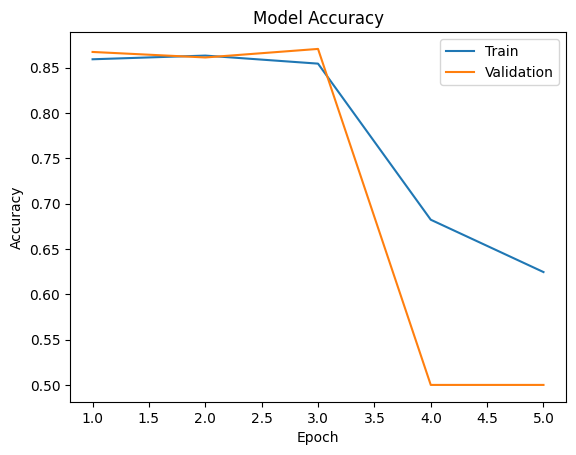

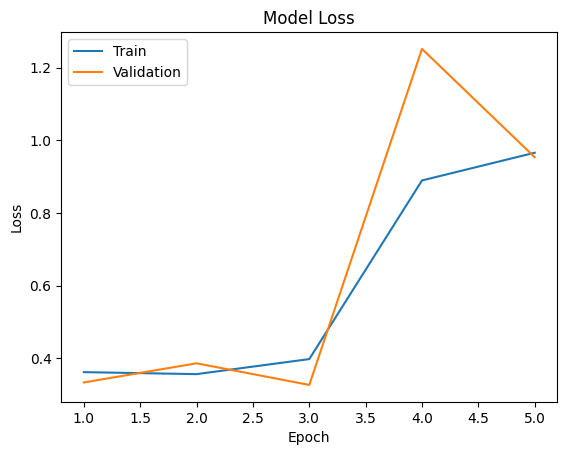

In [40]:
plotLearningCurve(history_cnn_rnn,5)

We can conclude simpleRNN model is our best pick.

### 40000 tokens

In [43]:
x_train = pd.read_pickle('x_train_final_clean.pkl')
x_test = pd.read_pickle('x_test_final_clean.pkl')

In [50]:
y_train = pd.read_pickle('y_train_final_clean.pkl')
y_test = pd.read_pickle('y_test_final_clean.pkl')

In [52]:
t = Tokenizer(oov_token='<UNK>')
t.fit_on_texts(x_train)
t.word_index['<PAD>'] = 0

In [53]:
word_counts = t.word_counts

# Sort words by frequency
sorted_words = sorted(word_counts.items(), key=lambda x: x[1], reverse=True)

# Trim vocabulary to top N words (e.g., top 50,000 words)
VOCAB_SIZE = 40000
trimmed_words = sorted_words[:VOCAB_SIZE]

# Create a new tokenizer with the trimmed vocabulary
trimmed_vocab = [word for word, count in trimmed_words]
trimmed_tokenizer = Tokenizer(num_words=VOCAB_SIZE , oov_token='<UNK>')
trimmed_tokenizer.fit_on_texts(trimmed_vocab)

In [54]:
train_sequences = trimmed_tokenizer.texts_to_sequences(x_train)
test_sequences = trimmed_tokenizer.texts_to_sequences(x_test)

In [56]:
x_train = sequence.pad_sequences(train_sequences, maxlen=105)
x_test = sequence.pad_sequences(test_sequences, maxlen=105)

In [57]:
EMBEDDING_DIM = 300
MAX_SEQUENCE_LENGTH = 105
VOCAB_SIZE = len(trimmed_tokenizer.word_index) 
print(len(trimmed_tokenizer.word_index)) 

40001


In [61]:
model_rnn = Sequential([
    Embedding(VOCAB_SIZE, EMBEDDING_DIM, input_length=MAX_SEQUENCE_LENGTH),
    SimpleRNN(50 , activation= 'relu' , kernel_regularizer= l2(0.01) , return_sequences= True),
    BatchNormalization(),
    Dropout(0.1),
    SimpleRNN(100 , activation= 'relu' , kernel_regularizer= l2(0.01)),
    Dropout(0.1),
    Dense(250 , activation= 'relu' , kernel_regularizer= l2(0.01)),
    Dropout(0.2),
    Dense(1 , activation= 'sigmoid' )])

In [63]:
model_rnn.build(input_shape=(None, MAX_SEQUENCE_LENGTH))
model_rnn.compile(optimizer= 'Adam', loss='binary_crossentropy', metrics=['binary_accuracy'])
model_rnn.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_4 (Embedding)         │ (None, 105, 300)       │    12,000,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_8 (SimpleRNN)        │ (None, 105, 50)        │        17,550 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 105, 50)        │           200 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 105, 50)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_9 (SimpleRNN)        │ (None, 100)            │        15,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 250)            │        25,250 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 250)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │           251 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,058,651 (46.00 MB)

 Trainable params: 12,058,551 (46.00 MB)

 Non-trainable params: 100 (400.00 B)

In [64]:
history_rnn = model_rnn.fit(x_train, y_train,validation_data=(x_test,y_test), epochs=5)

Epoch 1/5
112500/112500 ━━━━━━━━━━━━━━━━━━━━ 4245s 38ms/step - binary_accuracy: 0.8470 - loss: 0.3862 - val_binary_accuracy: 0.8972 - val_loss: 0.3241
Epoch 2/5
112500/112500 ━━━━━━━━━━━━━━━━━━━━ 4237s 38ms/step - binary_accuracy: 0.8977 - loss: 0.2932 - val_binary_accuracy: 0.5267 - val_loss: 0.7376
Epoch 3/5
112500/112500 ━━━━━━━━━━━━━━━━━━━━ 4226s 38ms/step - binary_accuracy: 0.8096 - loss: 0.4835 - val_binary_accuracy: 0.5000 - val_loss: 1.0126
Epoch 4/5
112500/112500 ━━━━━━━━━━━━━━━━━━━━ 4269s 38ms/step - binary_accuracy: 0.5261 - loss: 43.9183 - val_binary_accuracy: 0.5099 - val_loss: 0.8330
Epoch 5/5
112500/112500 ━━━━━━━━━━━━━━━━━━━━ 4245s 38ms/step - binary_accuracy: 0.5030 - loss: 95.5764 - val_binary_accuracy: 0.5000 - val_loss: 0.6932


We can Finally conclude increasing token size is contributing to overfitting. So we will save SimpleRNN model with  reduced train data for our app.